In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import io
import os
import pandas as pd

In [2]:
# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
device

device(type='mps')

In [3]:
# Hyperparameters
in_channel = 3
num_classes = 10
learning_rate = 1e-3
batch_size = 16
num_epochs = 1

In [8]:
class CatsAndDogsDataset(Dataset):

  def __init__(self, csv_file, root_dir, transform=None) :
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__ (self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.read_image(img_path)
    y_label = torch. tensor(int (self .annotations.iloc[index, 1]))

    if self.transform:
      image = self.transform(image)

    return (image, y_label)

### With Torchvision

In [16]:
my_transforms= transforms.Compose([
    transforms.ToPILImage(), #because all transformations works on this
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.ColorJitter(brightness= 0.5),
    transforms.RandomRotation(degrees= 45),
    transforms.RandomHorizontalFlip(p= 0.5),
    transforms.RandomVerticalFlip(p= 0.05),
    transforms.RandomGrayscale(p= 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.0, 0.0, 0.0], std= [1.0, 1.0, 1.0]), #in this we calculate mean value of all pixel channel wise and put values here and for std too of our training examples
    #(value-mean)/std it is done to normalise pixel value
    
])

In [17]:
dataset = CatsAndDogsDataset(csv_file = 'data/Persian_Car_Plates_YOLOV8/updated_temp.csv', root_dir = "", transform= my_transforms)

In [18]:
from torchvision.utils import save_image

img_num= 0
for _ in range(10):
    for img, label in dataset:
        save_image(img, "/Users/daniyalkhan/Documents/AI/DL/Pytorch/data/augmented/img_"+str(img_num)+".png")
        img_num+=1
        break

### With Albumentation lib

In [4]:
import cv2
import albumentations as A
import numpy as np
from utils import plot_examples
from PIL import Image #can use cv2 or pil for image handling

In [3]:
image= Image.open('data/albumentation/images/elon.jpeg')

In [6]:
transform= A.Compose([
    A.Resize(width= 1920, height= 1080),
    A.RandomCrop(width= 1080, height= 720),
    A.Rotate(limit= 40, p= 0.2, border_mode= cv2.BORDER_CONSTANT), #border constan so that if rotate then dont put image part in empty area
    A.HorizontalFlip(p= 0.5),
    A.VerticalFlip(p= 0.1), #do apply these transformation according to how things find in real time, dont just put any value for threshold and prob.
    A.RGBShift(r_shift_limit= 25, g_shift_limit= 25, b_shift_limit= 25, p= 0.2),
    A.OneOf([                           #this is for to apply any of from the list
        A.Blur(blur_limit= 3, p= 0.2),
        A.ColorJitter(p= 0.3)
    ], p= 0.1)
])

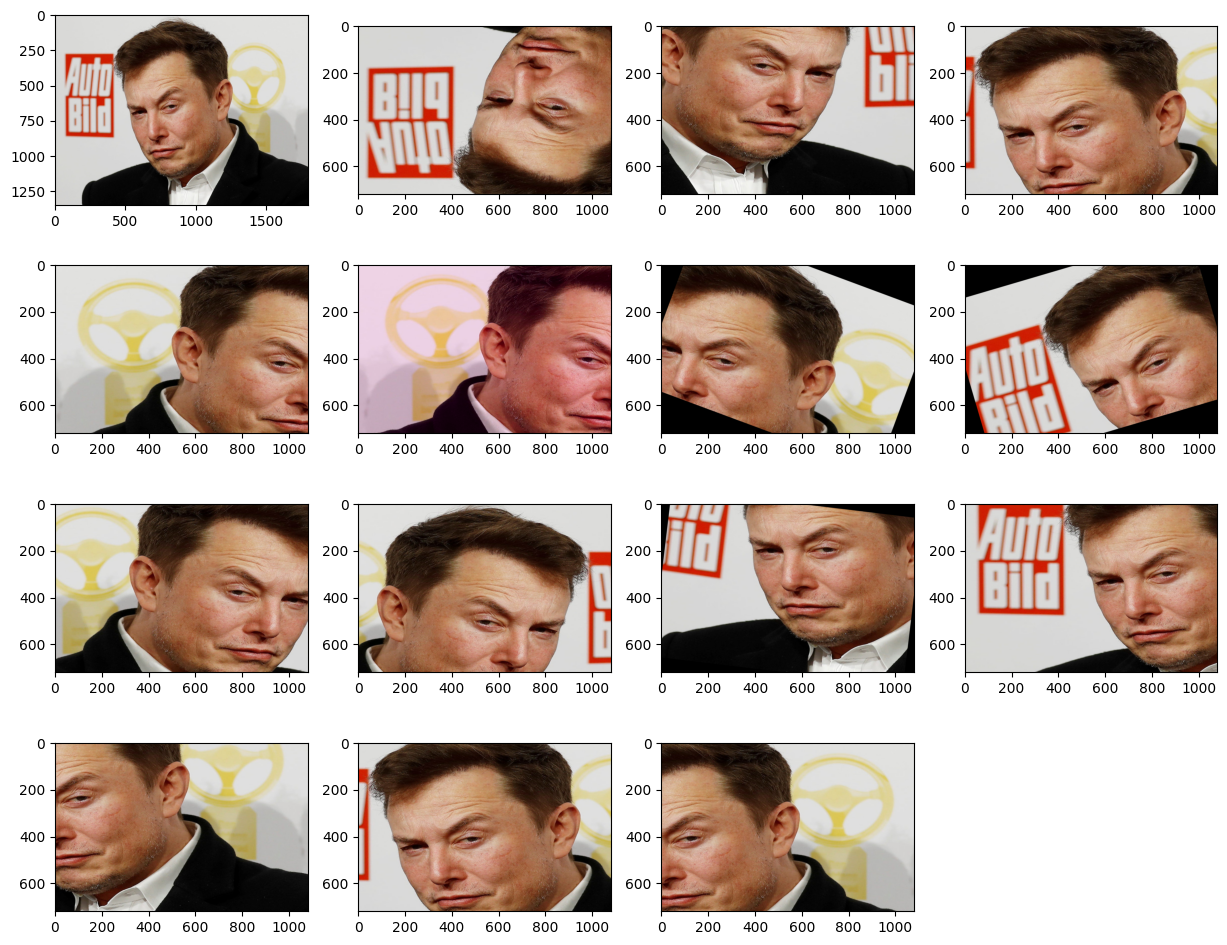

In [7]:
image_list= [image]
image= np.array(image)

for i in range(15):
    augmentations= transform(image= image)
    augmented_img= augmentations['image']
    image_list.append(augmented_img)

plot_examples(image_list)

#### Segmentation

In [8]:
#for segmentation we have a lot of benefits with this lib

In [13]:
image= Image.open('data/albumentation/images/elon.jpeg')
mask= Image.open('data/albumentation/images/mask.jpeg')

In [16]:
transform= A.Compose(
    [
    A.Resize(width= 1920, height= 1080),
    A.RandomCrop(width= 1080, height= 720),
    A.Rotate(limit= 40, p= 0.2, border_mode= cv2.BORDER_CONSTANT), #border constan so that if rotate then dont put image part in empty area
    A.HorizontalFlip(p= 0.5),
    A.VerticalFlip(p= 0.1), #do apply these transformation according to how things find in real time, dont just put any value for threshold and prob.
    A.RGBShift(r_shift_limit= 25, g_shift_limit= 25, b_shift_limit= 25, p= 0.2),
    A.OneOf([                           #this is for to apply any of from the list
        A.Blur(blur_limit= 3, p= 0.2),
        A.ColorJitter(p= 0.3)
    ], p= 0.1)
],
is_check_shapes= False)

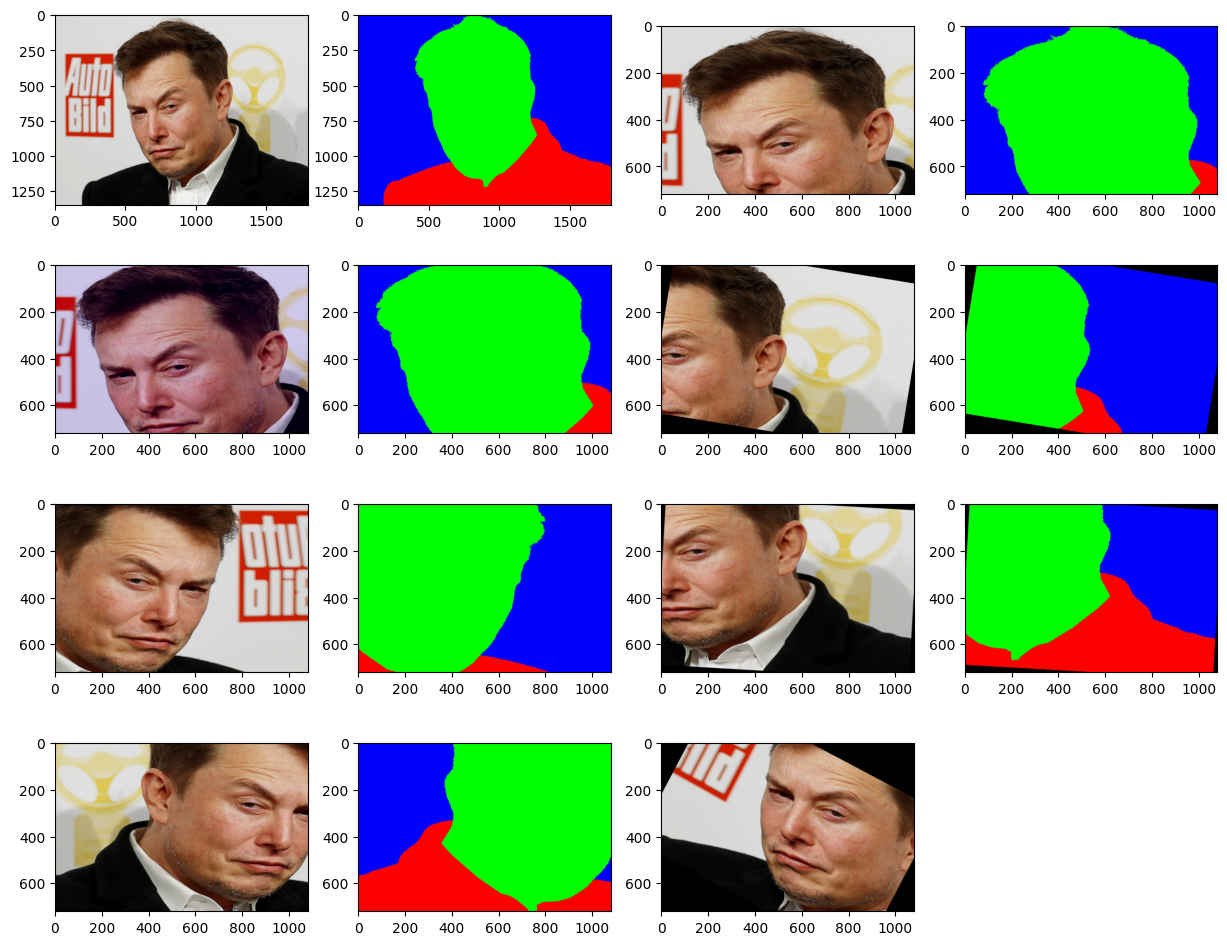

In [17]:
image_list= [image, mask]
image= np.array(image)
mask= np.array(mask)

for i in range(7):
    augmentations= transform(image= image, mask= mask)
    augmented_img= augmentations['image']
    augmented_mask= augmentations['mask']
    image_list.append(augmented_img)
    image_list.append(augmented_mask)

plot_examples(image_list)

In [18]:
#can have multiple mask for an image

(1080, 1080, 3) (1080, 1080, 3) (1080, 1080, 3)


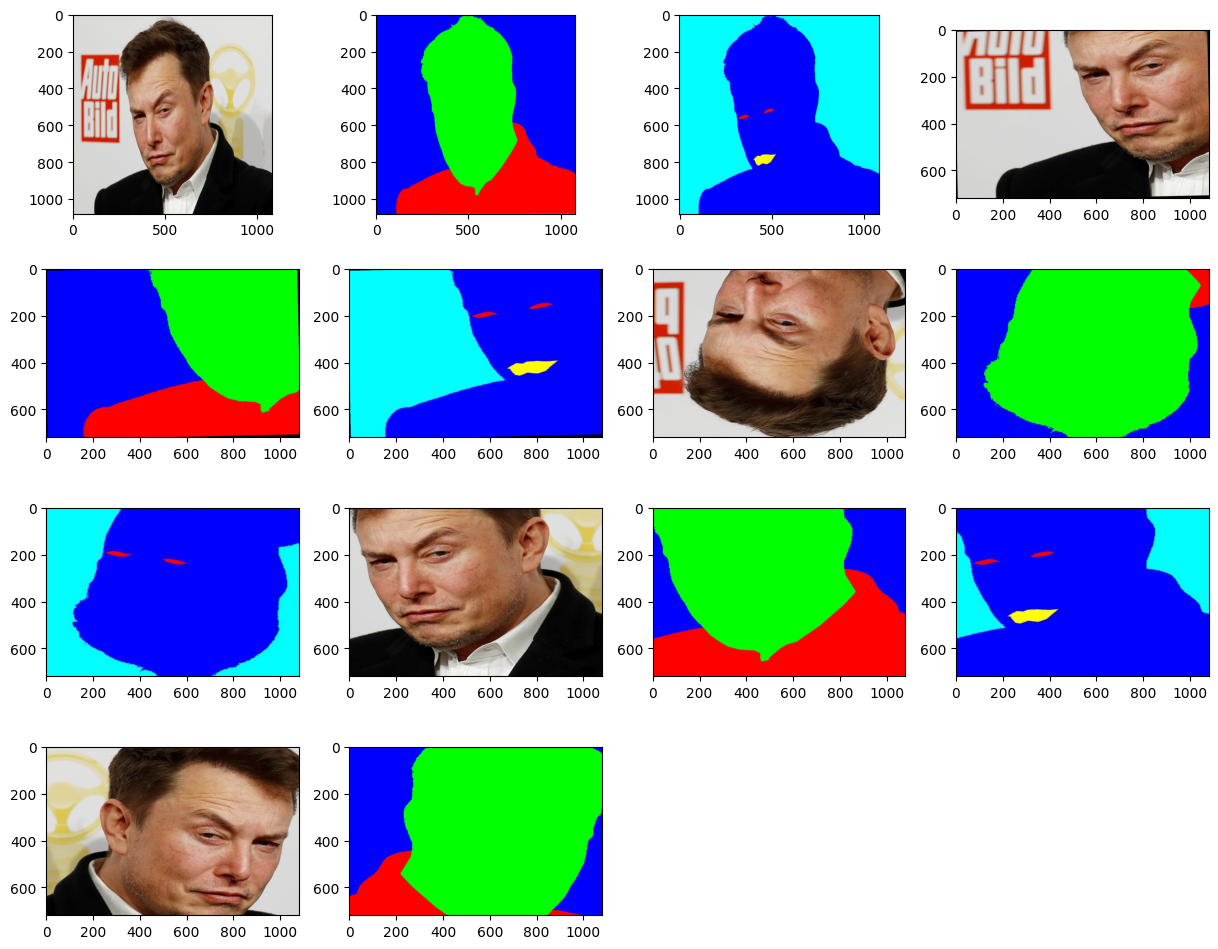

In [28]:
size= (1080, 1080)
image= Image.open('data/albumentation/images/elon.jpeg').resize(size)
mask= Image.open('data/albumentation/images/mask.jpeg').resize(size)
mask2= Image.open('data/albumentation/images/second_mask.jpeg').resize(size)
image_list= [image, mask, mask2]
image= np.array(image)
mask= np.array(mask)
mask2= np.array(mask2)

print(image.shape, mask.shape, mask2.shape)

for i in range(4):
    augmentations= transform(image= image, masks= [mask, mask2])
    augmented_img= augmentations['image']
    augmented_mask= augmentations['masks']
    image_list.append(augmented_img)
    image_list.append(augmented_mask[0])
    image_list.append(augmented_mask[1])

plot_examples(image_list)

#### Detection

In [52]:
image= cv2.imread('data/albumentation/images/cat.jpg')
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #as cv2 load image in bgr so need to convert into rgb
bboxes= [[13, 170, 224, 410]] #pascal_voc is (x_min, y_min, x_max, y_max), YOLO, COCO

In [61]:
transform= A.Compose(
    [
    A.Resize(width= 1920, height= 1080),
    A.RandomCrop(width= 1080, height= 720),
    A.Rotate(limit= 40, p= 0.2, border_mode= cv2.BORDER_CONSTANT),
    A.HorizontalFlip(p= 0.5),
    A.VerticalFlip(p= 0.1),
    A.RGBShift(r_shift_limit= 25, g_shift_limit= 25, b_shift_limit= 25, p= 0.2),
    A.OneOf([
        A.Blur(blur_limit= 3, p= 0.2),
        A.ColorJitter(p= 0.3)
    ], p= 0.1)
],
bbox_params= A.BboxParams(format= 'pascal_voc', 
                          min_area= 2048, #this means that bbox should have this much pixels as it can happen that augmentation just remove cat from img
                          min_visibility= 0.3,
                          label_fields= [])
)

[[566.0000114440918, 90.49998927116394, 1080.0, 630.5000214576721]]
[[574.0000114440918, 105.49998927116394, 1080.0, 645.5000214576721]]
[[0.0, 79.10453634607325, 492.4207580092742, 675.1144063994727]]
[[496.00001144409185, 198.49998927116394, 1080.0, 720.0]]


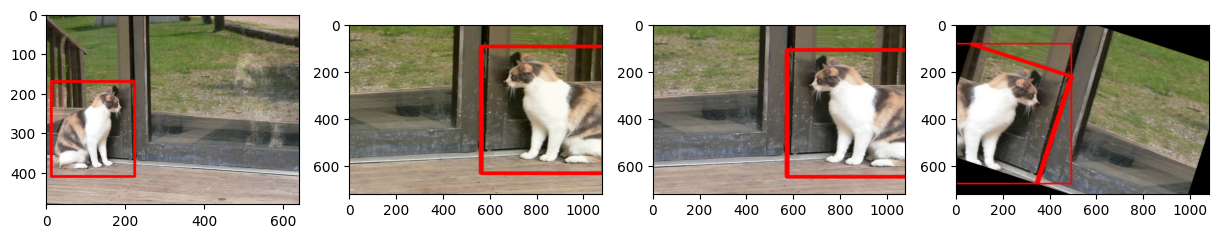

In [68]:
image_list= [image]
saved_bboxes= [bboxes[0]]

for i in range(6):
    augmentations= transform(image= image, bboxes= bboxes)
    augmented_img= augmentations['image']

    if len(augmentations['bboxes']) == 0:
        continue
    
    image_list.append(augmented_img)
    print(augmentations['bboxes'])
    saved_bboxes.append(augmentations['bboxes'][0])

plot_examples(image_list, saved_bboxes)

#### Putting in pipeline

In [5]:
from albumentations.pytorch import ToTensorV2

In [ ]:
#we can also give as transform argument or create a layer that do
class ImageFolder(nn.Module):

  def __init__(self, root_dir, transform=None):
    super().__init__()
    self.data= []
    self.root_dir = root_dir
    self.transform = transform
    self.class_name= os.listdir(root_dir)

    for idx, name in enumerate(self.class_name):
      files= os.listdir(os.path.join(self.root_dir, name))
      self.data= list(zip(files, [idx]*len(files)))

  def __len__ (self):
    return len(self.data)

  def __getitem__(self, index):
    img_file, label= self.data[index]
    img_file_path= os.path.join(self.root_dir, self.class_name[label])
    image= np.array(Image.open(os.path.join(img_file_path, img_file)))

    if self.transform is not None:
      augmentations= self.transform(image= image) #if have other params like bbox or mask then give param
      image= augmentations['image']


    return (image, label)

In [ ]:
transform= A.Compose([
    A.Resize(width= 1920, height= 1080),
    A.RandomCrop(width= 1080, height= 720),
    A.Rotate(limit= 40, p= 0.2, border_mode= cv2.BORDER_CONSTANT), #border constan so that if rotate then dont put image part in empty area
    A.HorizontalFlip(p= 0.5),
    A.VerticalFlip(p= 0.1), #do apply these transformation according to how things find in real time, dont just put any value for threshold and prob.
    A.RGBShift(r_shift_limit= 25, g_shift_limit= 25, b_shift_limit= 25, p= 0.2),
    A.OneOf([                           #this is for to apply any of from the list
        A.Blur(blur_limit= 3, p= 0.2),
        A.ColorJitter(p= 0.3)
    ], p= 0.1),
    A.Normalize( #this is same as torch normalize
        mean= [0.0, 0.0, 0.0],
        std= [1.0, 1.0, 1.0],
        max_pixel_value= 255
    ),
    ToTensorV2(), #using this now we are dividing by 255, which is happening in torch
])

In [16]:
dataset= ImageFolder(
    root_dir= '/Users/daniyalkhan/Documents/AI/DL/Pytorch/data/albumentation/cat_dog',
    transform= transform
)

/Users/daniyalkhan/Documents/AI/DL/Pytorch/data/albumentation/cat_dog/dogs
/Users/daniyalkhan/Documents/AI/DL/Pytorch/data/albumentation/cat_dog/cats


In [17]:
for x, y in dataset:
    print(x.shape, y)
    break

torch.Size([3, 720, 1080]) 1
